# Multi-class Multi-label classification| Support Vector Machine, K-Means 

### Scikit Learn, Python

Import needed libraries

In [1]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import statistics

from sklearn.datasets import make_multilabel_classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import hamming_loss
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report
from scipy.cluster.hierarchy import dendrogram, linkage
%matplotlib inline
from sklearn.metrics import accuracy_score

#### Each instance has three labels: Families, Genus, and Species. Each of the labels has multiple classes. We wish to solve a multi-class and multi-label problem. One of the most important approaches to multi-class classification is to train a classifier for each label. We first try this approach:

In [2]:
#ref https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff
df = pd.read_csv('Frogs_MFCCs.csv')
print("Number of rows in data =",df.shape[0])
print("Number of columns in data =",df.shape[1])
print("\n")
print("**Sample data:**")
df.head()


Number of rows in data = 7195
Number of columns in data = 26


**Sample data:**


,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre,1
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre,1
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre,1
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,Adenomera,AdenomeraAndre,1
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,Adenomera,AdenomeraAndre,1


In [3]:
df.columns

Index(['MFCCs_ 1', 'MFCCs_ 2', 'MFCCs_ 3', 'MFCCs_ 4', 'MFCCs_ 5', 'MFCCs_ 6',
       'MFCCs_ 7', 'MFCCs_ 8', 'MFCCs_ 9', 'MFCCs_10', 'MFCCs_11', 'MFCCs_12',
       'MFCCs_13', 'MFCCs_14', 'MFCCs_15', 'MFCCs_16', 'MFCCs_17', 'MFCCs_18',
       'MFCCs_19', 'MFCCs_20', 'MFCCs_21', 'MFCCs_22', 'Family', 'Genus',
       'Species', 'RecordID'],
      dtype='object')

#### Exact match and hamming score/ loss methods for evaluating multilabel classification and use them in evaluating the classifiers in this problem.

Exact Match : Exact Match is the Google keyword match type that allows you to show your ad when a searcher types the exact word or phrase you are bidding on. An Exact Match keyword in Google AdWords will only enter an auction in which the search query perfectly matches or is a close variant of your keyword.
#ref https://www.wordstream.com/exact-match


Hamming Loss : the fraction of the wrong labels to the total number of labels.Optimal value is 0.


Hamming Score : accuracy in the multi-label setting, defined as the number of correct labels divided by the union of prediction and true labels.
#ref:https://pdfs.semanticscholar.org/a928/fb1f6279a5c05e9a98bea20fe712372118c6.pdf


Hamming distance : it is a categorical distance. For categorical variables we can measure whether the variables are same or not.
given by :noOfMatchAttributes / noOfAttributes
#https://dzone.com/articles/machine-learning-measuring

In [75]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:22],df.iloc[:,22:], test_size=0.3)

In [76]:
y_train_family = pd.DataFrame(y_train.iloc[:,0])
y_test_family = pd.DataFrame(y_test.iloc[:,0])
y_train_genus = pd.DataFrame(y_train.iloc[:,1])
y_test_genus = pd.DataFrame(y_test.iloc[:,1])
y_train_species = pd.DataFrame(y_train.iloc[:,2])
y_test_species = pd.DataFrame(y_test.iloc[:,2])

##### Training data using SVM.

#https://www.quora.com/What-are-C-and-gamma-with-regards-to-a-support-vector-machine -> understanding of values of hyperparameters and their influence on margin of the hyperplane

In [77]:
C_range = [10**x for x in range(-3,6,1)]
gamma_range = [x for x in np.arange(0.1,2,0.1)]
param_grid = dict(gamma=gamma_range, C=C_range)
svm_family = SVC(kernel="rbf" )
clf_family = GridSearchCV(svm_family,param_grid, cv=10)
clf_family.fit(X_train, y_train_family)
y_pred_family_svc =clf_family.predict(X_test)
y_pred_family_svc =clf_family.predict(X_test)
print("SVM for Family Label using Gaussian Kernels and one vs all classifier:\n")
print("Confidence Scores for train data:{}".format(clf_family.score(X_train, y_train_family)))
print("Confidence Score for test data :{}".format(clf_family.score(X_test, y_pred_family_svc)))
print("Best scores :{}".format(clf_family.best_score_ ))
print("Best C and Gamma Values :{}".format(clf_family.best_params_ ))
print( "Hamming Loss :{}".format(hamming_loss(y_test_family, y_pred_family_svc)))
def hamming_distance(s1, s2):
    assert len(s1) == len(s2)
    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))
 
if __name__=="__main__":
    print ("Hamming Distance :{} ".format(hamming_distance(y_test_family, y_pred_family_svc))) 


SVM for Family Label using Gaussian Kernels and one vs all classifier:

Confidence Scores for train data:1.0
Confidence Score for test data :1.0
Best scores :0.9914614773629865
Best C and Gamma Values :{'C': 100, 'gamma': 1.9000000000000001}
Hamming Loss :0.0037054191755442334
Hamming Distance :1 


In [78]:
print("Exact match :{}".format(accuracy_score(y_test_family, y_pred_family_svc)))

Exact match :0.9962945808244558


In [79]:
C_range = [10**x for x in range(-3,6,1)]
gamma_range = [x for x in np.arange(0.1,2,0.1)]
param_grid = dict(gamma=gamma_range, C=C_range)
svm_genus = SVC(kernel="rbf" )
clf_genus = GridSearchCV(svm_genus,param_grid, cv=10)
clf_genus.fit(X_train, y_train_genus)
y_pred_genus_svc =clf_genus.predict(X_test)
y_pred_genus_svc =clf_genus.predict(X_test)
print("SVM for genus label using Gaussian Kernels and one vs all classifier:\n")
print("Confidence Scores for train data:{}".format(clf_genus.score(X_train, y_train_genus)))
print("Confidence Score for test data :{}".format(clf_genus.score(X_test, y_pred_genus_svc)))
#print("cross validation result :{}".format(clf_genus.cv_results_))
print("Best scores :{}".format(clf_genus.best_score_ ))
print("Best C and Gamma Values :{}".format(clf_genus.best_params_ ))
print( "Hamming Loss :{}".format(hamming_loss(y_test_genus, y_pred_genus_svc)))
def hamming_distance(s1, s2):
    assert len(s1) == len(s2)
    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))
 
if __name__=="__main__":
    print ("Hamming Distance :{} ".format(hamming_distance(y_test_genus, y_pred_genus_svc))) 

SVM for genus label using Gaussian Kernels and one vs all classifier:

Confidence Scores for train data:1.0
Confidence Score for test data :1.0
Best scores :0.9910643367752184
Best C and Gamma Values :{'C': 100, 'gamma': 1.2000000000000002}
Hamming Loss :0.008800370541917554
Hamming Distance :1 


In [14]:
print("Exact match :{}".format(accuracy_score(y_test_genus, y_pred_genus_svc)))

Exact match :0.9888837424733673


In [16]:
C_range = [10**x for x in range(-3,6,1)]
gamma_range = [x for x in np.arange(0.1,2,0.1)]
param_grid = dict(gamma=gamma_range, C=C_range)
svm_species = SVC(kernel="rbf" )
clf_species = GridSearchCV(svm_species,param_grid, cv=10)
clf_species.fit(X_train, y_train_species)
y_pred_species_svc =clf_species.predict(X_test)
y_pred_species_svc =clf_species.predict(X_test)
print("SVM for species label using Gaussian Kernels and one vs all classifier:\n")
print("Confidence Scores for train data:{}".format(clf_species.score(X_train, y_train_species)))
print("Confidence Score for test data :{}".format(clf_species.score(X_test, y_pred_species_svc)))
#print("cross validation result :{}".format(clf_species.cv_results_))
print("Best scores :{}".format(clf_species.best_score_ ))
print("Best C and Gamma Values :{}".format(clf_species.best_params_ ))
print( "Hamming Loss :{}".format(hamming_loss(y_test_species, y_pred_species_svc)))
print("Exact match :{}".format(accuracy_score(y_test_species, y_pred_species_svc)))
def hamming_distance(s1, s2):
    assert len(s1) == len(s2)
    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))
 
if __name__=="__main__":
    print ("Hamming Distance :{} ".format(hamming_distance(y_test_species, y_pred_species_svc))) 


SVM for species label using Gaussian Kernels and one vs all classifier:

Confidence Scores for train data:0.9193804606830818
Confidence Score for test data :1.0
Best scores :0.8880063542494043
Best C and Gamma Values :{'C': 0.1, 'gamma': 0.4}
Hamming Loss :0.07410838351088467
Exact match :0.9258916164891153
Hamming Distance :1 


##### Repeating process using L1-penalized SVMs and  determined weights of the SVM penalty using 10 fold cross validation.

In [23]:
scaler = StandardScaler()
X_train_std = scaler.fit(X_train).transform(X_train)
X_test_std = scaler.fit(X_test).transform(X_test)
C_range_l1 = np.logspace(-3,6,10)
param_grid = dict( C=C_range_l1)
svm_l1_genus = svm.LinearSVC(loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l1',dual=False)
clf_l1_genus = GridSearchCV(svm_l1_genus,param_grid, cv=10)
clf_l1_genus.fit(X_train, y_train_genus)
y_pred_l1_genus_svc =clf_l1_genus.predict(X_test_std)
print("SVM with L1 penality for genus label :\n")
print("Confidence Scores for train data:{}".format(clf_l1_genus.score(X_train, y_train_genus)))
print("Confidence Score for test data :{}".format(clf_l1_genus.score(X_test, y_pred_l1_genus_svc)))
#print("cross validation result :{}".format(clf_l1_genus.cv_results_))
print("Best C and Gamma values :{}".format(clf_l1_genus.best_score_ ))
print("Best parameters :{}".format(clf_l1_genus.best_params_ ))
print( "Hamming Loss :{}".format(hamming_loss(y_test_genus, y_pred_l1_genus_svc)))
print("Exact match :{}".format(accuracy_score(y_test_genus, y_pred_l1_genus_svc)))

SVM with L1 penality for genus label :

Confidence Scores for train data:0.9471803018268466
Confidence Score for test data :0.7156090782769801
Best C and Gamma values :0.9457903097696585
Best parameters :{'C': 10.0}
Hamming Loss :0.07410838351088467
Exact match :0.9258916164891153


In [30]:
def hamming_distance(s1, s2):
    assert len(s1) == len(s2)
    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))
 
if __name__=="__main__":
    print ("Hamming Distance :{} ".format(hamming_distance(y_test_genus, y_pred_l1_genus_svc))) 

Hamming Distance :1 


In [28]:
scaler = StandardScaler()
X_train_std = scaler.fit(X_train).transform(X_train)
X_test_std = scaler.fit(X_test).transform(X_test)
C_range_L1 = np.logspace(-3,6,10)
param_grid = dict( C=C_range_l1)
svm_l1_family = svm.LinearSVC(loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l1',dual=False)
clf_l1_family = GridSearchCV(svm_l1_family,param_grid, cv=10)
clf_l1_family.fit(X_train, y_train_family)
y_pred_l1_family_svc =clf_l1_family.predict(X_test_std)
print("SVM with L1 penality for family label :\n")
print("Confidence Scores for train data:{}".format(clf_l1_family.score(X_train, y_train_family)))
print("Confidence Score for test data :{}".format(clf_l1_family.score(X_test, y_pred_l1_family_svc)))
#print("cross validation result :{}".format(clf_l1_family.cv_results_))
print("Best scores :{}".format(clf_l1_family.best_score_ ))
print("Best parameters :{}".format(clf_l1_family.best_params_ ))
print( "Hamming Loss :{}".format(hamming_loss(y_test_family, y_pred_l1_family_svc)))
print("Exact match :{}".format(accuracy_score(y_test_family, y_pred_l1_family_svc)))

SVM with L1 penality for family label :

Confidence Scores for train data:0.937450357426529
Confidence Score for test data :0.7410838351088467
Best scores :0.9322875297855441
Best parameters :{'C': 10000.0}
Hamming Loss :0.26308476146364057
Exact match :0.7369152385363594


In [31]:
def hamming_distance(s1, s2):
    assert len(s1) == len(s2)
    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))
 
if __name__=="__main__":
    print ("Hamming Distance :{} ".format(hamming_distance(y_test_family, y_pred_l1_family_svc))) 

Hamming Distance :1 


In [29]:
scaler = StandardScaler()
X_train_std = scaler.fit(X_train).transform(X_train)
X_test_std = scaler.fit(X_test).transform(X_test)
C_range_L1 = np.logspace(-3,6,10)
param_grid = dict( C=C_range_l1)
svm_l1_species = svm.LinearSVC(loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l1',dual=False)
clf_l1_species = GridSearchCV(svm_l1_species,param_grid, cv=10)
clf_l1_species.fit(X_train, y_train_species)
y_pred_l1_species_svc =clf_l1_species.predict(X_test_std)
print("SVM with L1 penality for species label:\n")
print("Confidence Scores for train data:{}".format(clf_l1_species.score(X_train, y_train_species)))
print("Confidence Score for test data :{}".format(clf_l1_species.score(X_test, y_pred_l1_species_svc)))
#print("cross validation result :{}".format(clf_l1_species.cv_results_))
print("Best scores :{}".format(clf_l1_species.best_score_ ))
print("Best parameters :{}".format(clf_l1_species.best_params_ ))
print( "Hamming Loss :{}".format(hamming_loss(y_test_species, y_pred_l1_species_svc)))
print("Exact match :{}".format(accuracy_score(y_test_species, y_pred_l1_species_svc)))

SVM with L1 penality for species label:

Confidence Scores for train data:0.9612787926926132
Confidence Score for test data :0.8601204261232052
Best scores :0.9567116759332804
Best parameters :{'C': 100.0}
Hamming Loss :0.14960629921259844
Exact match :0.8503937007874016


In [32]:
def hamming_distance(s1, s2):
    assert len(s1) == len(s2)
    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))
 
if __name__=="__main__":
    print ("Hamming Distance :{} ".format(hamming_distance(y_test_species, y_pred_l1_species_svc))) 

Hamming Distance :1 


##### Applying SMOTE for class imbalance

In [35]:
#standardization
scaler = StandardScaler()
X_train_std = scaler.fit(X_train).transform(X_train)
X_test_std = scaler.fit(X_test).transform(X_test)

#smote
X_smote_train,Y_smote_train_family = SMOTE().fit_resample(X_train_std,y_train_family)
X_smote_test,Y_smote_test_family = SMOTE().fit_resample(X_test_std,y_test_family)

#SVM
C_range_smote = [10**x for x in range(-3,6,1)]
param_grid = dict( C=C_range_smote)
svm_smote_family = svm.LinearSVC(loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l1',dual=False)
clf_smote_family = GridSearchCV(svm_smote_family,param_grid, cv=10)
clf_smote_family.fit(X_smote_train,Y_smote_train_family)
y_pred_family_smote =clf_smote_family.predict(X_smote_test)
print("SVM after applying SMOTE for imbalance for family label:\n")
print("Confidence Score for test data :{}".format(clf_smote_family.score(X_smote_test, y_pred_family_smote)))
#print("cross validation result :{}".format(clf_smote_family.cv_results_))
print("Best scores :{}".format(clf_smote_family.best_score_ ))
print("Best scores :{}".format(clf_smote_family.best_params_ ))
print( "Hamming Loss :{}".format(hamming_loss(Y_smote_test_family, y_pred_family_smote)))
print("Exact match :{}".format(accuracy_score(Y_smote_test_family, y_pred_family_smote)))

SVM after applying SMOTE for imbalance for family label:

Confidence Score for test data :1.0
Best scores :0.9469549724651766
Best scores :{'C': 10}
Hamming Loss :0.046511627906976744
Exact match :0.9534883720930233


In [36]:
def hamming_distance(s1, s2):
    assert len(s1) == len(s2)
    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))
 
if __name__=="__main__":
    print ("Hamming Distance :{} ".format(hamming_distance(Y_smote_test_family, y_pred_family_smote))) 

Hamming Distance :248 


In [39]:
#standardization
scaler = StandardScaler()
X_train_std = scaler.fit(X_train).transform(X_train)
X_test_std = scaler.fit(X_test).transform(X_test)

#smote
X_smote_train,Y_smote_train_species = SMOTE().fit_resample(X_train_std,y_train_species)
X_smote_test,Y_smote_test_species = SMOTE().fit_resample(X_test_std,y_test_species)

#SVM
C_range_smote = [10**x for x in range(-3,6,1)]
param_grid = dict( C=C_range_smote)
svm_smote_species = svm.LinearSVC(loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l1',dual=False)
clf_smote_species = GridSearchCV(svm_smote_species,param_grid, cv=10)
clf_smote_species.fit(X_smote_train,Y_smote_train_species)
y_pred_species_smote =clf_smote_species.predict(X_smote_test)
print("SVM after applying SMOTE for imbalance for species label:\n")
print("Confidence Score for test data :{}".format(clf_smote_species.score(X_smote_test, y_pred_species_smote)))
#print("cross validation result :{}".format(clf_smote_species.cv_results_))
print("Best scores :{}".format(clf_smote_species.best_score_ ))
print("Best scores :{}".format(clf_smote_species.best_params_ ))
print( "Hamming Loss :{}".format(hamming_loss(Y_smote_test_species, y_pred_species_smote)))
print("Exact match :{}".format(accuracy_score(Y_smote_test_species, y_pred_species_smote)))
def hamming_distance(s1, s2):
    assert len(s1) == len(s2)
    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))
 
if __name__=="__main__":
    print ("Hamming Distance :{} ".format(hamming_distance(Y_smote_test_species, y_pred_species_smote))) 

SVM after applying SMOTE for imbalance for species label:

Confidence Score for test data :1.0
Best scores :0.9602722772277228
Best scores :{'C': 1}
Hamming Loss :0.042599620493358636
Exact match :0.9574003795066414
Hamming Distance :449 


In [40]:
#standardization
scaler = StandardScaler()
X_train_std = scaler.fit(X_train).transform(X_train)
X_test_std = scaler.fit(X_test).transform(X_test)

#smote
X_smote_train,Y_smote_train_genus = SMOTE().fit_resample(X_train_std,y_train_genus)
X_smote_test,Y_smote_test_genus = SMOTE().fit_resample(X_test_std,y_test_genus)

#SVM
C_range_smote = [10**x for x in range(-3,6,1)]
param_grid = dict( C=C_range_smote)
svm_smote_genus = svm.LinearSVC(loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l1',dual=False)
clf_smote_genus = GridSearchCV(svm_smote_genus,param_grid, cv=10)
clf_smote_genus.fit(X_smote_train,Y_smote_train_genus)
y_pred_genus_smote =clf_smote_genus.predict(X_smote_test)
print("SVM after applying SMOTE for imbalance for genus label:\n")
print("Confidence Score for test data :{}".format(clf_smote_genus.score(X_smote_test, y_pred_genus_smote)))
#print("cross validation result :{}".format(clf_smote_genus.cv_results_))
print("Best scores :{}".format(clf_smote_genus.best_score_ ))
print("Best scores :{}".format(clf_smote_genus.best_params_ ))
print( "Hamming Loss :{}".format(hamming_loss(Y_smote_test_genus, y_pred_genus_smote)))
print("Exact match :{}".format(accuracy_score(Y_smote_test_genus, y_pred_genus_smote)))
def hamming_distance(s1, s2):
    assert len(s1) == len(s2)
    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))
 
if __name__=="__main__":
    print ("Hamming Distance :{} ".format(hamming_distance(Y_smote_test_genus, y_pred_genus_smote))) 

SVM after applying SMOTE for imbalance for genus label:

Confidence Score for test data :1.0
Best scores :0.957167530224525
Best scores :{'C': 1}
Hamming Loss :0.05567729083665339
Exact match :0.9443227091633466
Hamming Distance :559 


Upon applying smote to balance the imbalanced classes, hamming loss and exact match have changed

####  K-Means Clustering on a Multi-Class and Multi-Label Data Set
##### Monte-Carlo Simulation: Perform the following procedures 50 times, and report the average and standard deviation of the 50 Hamming Distances that you calculate.
#####  k-means clustering on the whole Anuran Calls (MFCCs) Data Set (do not split the data into train and test, as we are not performing supervised learning in this exercise). Choose k in {1,2,.. 50} automatically based on one of the methods provided in the slides (CH or Gap Statistics or scree plots or Silhouettes) or any other method you know.
##### Determining which family is the majority by reading the true labels. Repeat for genus and species.
##### Average Hamming distance, Hamming score, and Hamming loss between the true labels and the labels assigned by clusters.

In [87]:
X_kMeans = df.iloc[:,:22]
Y_kMeans = df.iloc[:,22:25]

In [42]:
from sklearn.metrics import hamming_loss

cols=[e for e in df if e not in ( 'Family','Genus','Species')]
X_kMeans=df.loc[:,cols]
Y_kMeans=df.loc[:, ['Family','Genus','Species']]

hamming_loss_val=[]
hamming_score_val=[]

majority_family={p:[] for p in range(1,51)}
majority_genus={p:[] for p in range(1,51)}
majority_species={p:[] for p in range(1,51)}

In [81]:
p=51
j=51
i=21
for cls in range(1,p):
    sillhouettes_avg = dict()
    for k in range(2,j):
        rand_value=random.randint(0, i)
        k_means = KMeans(n_clusters=k,init='k-means++',random_state=rand_value).fit(X_kMeans)
        labels = k_means.labels_
        sillhouettes_avg.update({k:(metrics.silhouette_score(X_kMeans, labels))})
    optimal_k = max(sillhouettes_avg,key=sillhouettes_avg.get)
    rand_value=random.randint(0, i)
    X_kMeans1=X_kMeans
    k_means_f = KMeans(n_clusters=4, random_state=rand_value).fit(X_kMeans1)
    cluster_labels = k_means_f.labels_
    clusters = pd.concat([X_kMeans1,Y_kMeans,pd.DataFrame({'labels':cluster_labels.tolist()})],axis = 1)
    clusters['labels'].value_counts()
    for k in range(4):
        find= clusters[clusters['labels']==k]
        ### below lines output the majority class in each label :2(b)
        #print('Cluster',k+1)
        #print('\nMajority class in family - ',find['Family'].value_counts().index[0])
        #print('Majority class in genus - ',find['Genus'].value_counts().index[0])
        #print('Majority class in species - ',find['Species'].value_counts().index[0])
        #print('\n')

    majority_all = {k:[] for k in range(4)}
    for k in range(4):
        c_value = clusters[clusters['labels']==k]
        majority_all[k].append(c_value['Family'].value_counts().index[0])
        majority_all[k].append(c_value['Genus'].value_counts().index[0])
        majority_all[k].append(c_value['Species'].value_counts().index[0])
        majority_family[cls].append(c_value['Family'].value_counts().index[0])
        majority_genus[cls].append(c_value['Genus'].value_counts().index[0])
        majority_species[cls].append(c_value['Species'].value_counts().index[0])
    clusters['family_pred'] = 'none'
    clusters['genus_pred'] = 'none'
    clusters['species_pred'] = 'none'
    for k in range(4):
        clusters['family_pred'] = np.where(clusters['labels']==k,majority_all[k][0],clusters['family_pred'])
        clusters['genus_pred'] = np.where(clusters['labels']==k,majority_all[k][1],clusters['genus_pred'])
        clusters['species_pred'] = np.where(clusters['labels']==k,majority_all[k][2],clusters['species_pred'])
    hamming_family=hamming_loss(clusters['Family'],clusters['family_pred'])
    hamming_genus=hamming_loss(clusters['Genus'],clusters['genus_pred'])
    hamming_species=hamming_loss(clusters['Species'],clusters['species_pred'])
    ham_loss_s=(hamming_family+hamming_genus+hamming_species)/3
    hamming_loss_val.append(np.round(ham_loss_s,6))
    hamming_score_val.append((1-ham_loss_s))

In [82]:
print("Majority in Family Label by cluster :\n{}".format(find['Family'].value_counts()))
print("Majority in Genus Label by cluster :\n{}".format(find['Genus'].value_counts()))
print("Majority in Species Label by cluster :\n{}".format(find['Species'].value_counts()))

Majority in Family Label by cluster :
Hylidae            1730
Leptodactylidae      43
Name: Family, dtype: int64
Majority in Genus Label by cluster :
Hypsiboas        1593
Dendropsophus     137
Leptodactylus      43
Name: Genus, dtype: int64
Majority in Species Label by cluster :
HypsiboasCordobae       1121
HypsiboasCinerascens     472
HylaMinuta               137
LeptodactylusFuscus       43
Name: Species, dtype: int64


In [83]:
print("Standart Deviation of 50 Hamming Score: {}".format(statistics.stdev(hamming_score_val)))
print("Average of the 50 Hamming Score : {}".format(statistics.mean(hamming_score_val)))
print("Standart Deviation of 50 Hamming Loss : {}".format(statistics.stdev(hamming_loss_val)))
print("Average of the 50 Hamming Loss : {}".format(statistics.mean(hamming_loss_val)))

Standart Deviation of 50 Hamming Score: 0.008694727891744506
Average of the 50 Hamming Score : 0.7887669328967034
Standart Deviation of 50 Hamming Loss : 0.008694745715405112
Average of the 50 Hamming Loss : 0.211233


#### Dendroid based on dissimilarity matrix

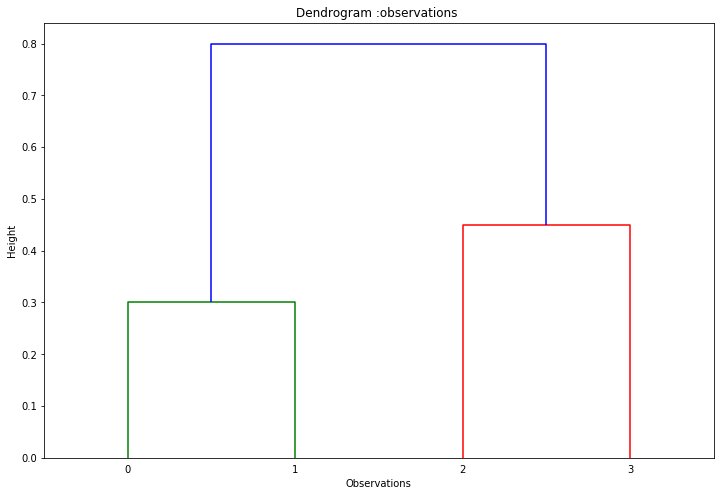

In [84]:
from scipy.cluster.hierarchy import dendrogram, linkage
dissimilarity_matrix = np.array([[0,0.3,0.4,0.7],
                                 [0.3,0,0.5,0.8],
                                [0.4,0.5,0,0.45],
                                [0.7,0.8,0.45,0]])
height, width = dissimilarity_matrix.shape
dend = linkage(dissimilarity_matrix[np.triu_indices(height,1)], method='complete')
plt.figure(figsize=(12,8))
plt.title('Dendrogram :observations ')
plt.xlabel('Observations')
plt.ylabel('Height')
dendrogram(dend,leaf_rotation=0,leaf_font_size=10)
plt.show()

#### Single linkage clustering.

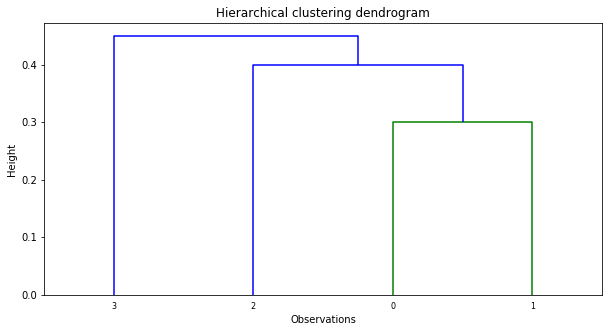

In [85]:
# Linkage matrix
dissimilarity_matrix = np.array([[0,0.3,0.4,0.7],
                                 [0.3,0,0.5,0.8],
                                [0.4,0.5,0,0.45],
                                [0.7,0.8,0.45,0]])
height, width = dissimilarity_matrix.shape
z = linkage(dissimilarity_matrix[np.triu_indices(height,1)], method='single')
plt.figure(figsize=(10,5))
plt.title('Hierarchical clustering dendrogram')
plt.xlabel('Observations')
plt.ylabel('Height')

dendrogram(z, leaf_rotation=0, leaf_font_size=8)
plt.show()